In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from whispervqconv import WhisperForConditionalGeneration, Model
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor
import librosa
import numpy as np
import torch

torch.set_grad_enabled(False)

In [3]:
# !ls whisperconv

In [4]:
# model = Model.from_pretrained(
#     'whisperconv/checkpoint-42000', torch_dtype = 'auto').train()
# # model.model.init_quantize_layer()

In [5]:
# _ = model.cuda()

In [6]:
# feature_extractor = AutoFeatureExtractor.from_pretrained('openai/whisper-large-v3-turbo')
# tokenizer = AutoTokenizer.from_pretrained('openai/whisper-large-v3-turbo')
# processor = AutoProcessor.from_pretrained('openai/whisper-large-v3-turbo')

In [7]:
# from streaming import MDSWriter, LocalDataset

# dataset = LocalDataset('mosaic-stt-include-malaysian')

In [8]:
# import random

# indices = set()
# while len(indices) < 20000:
#     i = random.randint(0, len(dataset) - 1)
#     if i in indices:
#         continue
#     indices.add(i)

In [9]:
# from tqdm import tqdm

# projections = []
# for i in tqdm(indices):
    
#     y, sr = librosa.load(dataset[i]['audio_filename'], sr = feature_extractor.sampling_rate)
#     features = feature_extractor(
#         [y], return_tensors = 'pt', 
#         sampling_rate=feature_extractor.sampling_rate,
#         return_attention_mask=True)
#     for k in features.keys():
#         features[k] = features[k].cuda()

#     encoder_outputs = model.model.encoder(**features)
#     attention_mask = features['attention_mask'][:,::4].unsqueeze(-1)
#     hidden_states = encoder_outputs[0]
#     hidden_states = hidden_states.permute(0, 2, 1)
#     hidden_states = model.model.avg_pooler(hidden_states)
#     hidden_states = hidden_states.permute(0, 2, 1)
#     hidden_states = hidden_states * attention_mask
#     d = hidden_states[0, attention_mask[0,:,0] == 1].cpu().numpy()
#     projections.append(d)

In [10]:
# np.save('projections-whisper-conv.npy', np.concatenate(projections))

In [11]:
projections = np.load('projections-whisper-conv.npy')
projections.shape

(2591650, 1280)

In [12]:
# done the same on second GPU
# feel free to scale up

projections_part2 = np.load('projections-whisper-conv-part2.npy')
projections_part2.shape

(2666389, 1280)

In [13]:
projections = [projections, projections_part2]
projections = np.concatenate(projections)

In [14]:
import torch.nn.functional as F
from tqdm import tqdm

batch_size = 128
n_clusters = 32768
latent_dim = 1280
device = 'cuda'

@torch.no_grad()
def kmeans_plus_plus_init(X, n_clusters, device='cuda'):
    """
    Fast KMeans++ initialization with incremental distance update.
    """
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    X = X.to(device)

    N, D = X.shape
    centroids = torch.empty(n_clusters, D, device=device)

    # Choose first centroid randomly
    i = torch.randint(0, N, (1,))
    centroids[0] = X[i]

    # Initialize closest distances for each point
    min_distances = torch.cdist(X, centroids[0:1]).squeeze(1).pow(2)  # [N]

    for k in tqdm(range(1, n_clusters)):
        probs = min_distances / min_distances.sum()
        next_idx = torch.multinomial(probs, 1)
        centroids[k] = X[next_idx]

        # Update min_distances incrementally
        dist_to_new = torch.cdist(X, centroids[k:k+1]).squeeze(1).pow(2)
        min_distances = torch.minimum(min_distances, dist_to_new)

    return centroids

In [15]:
cache_file = 'conv-centroids++-v2.npy'
sample = torch.randint(low = 0, high = projections.shape[0] - 1, size = (1000000,))
centroids = kmeans_plus_plus_init(projections[sample], n_clusters, device=device)
np.save(cache_file, centroids.cpu().numpy())

100%|█████████████████████████████████████| 32767/32767 [25:02<00:00, 21.80it/s]


In [16]:
counts = torch.zeros(n_clusters, device=device)

for i in tqdm(range(0, len(projections), batch_size)):
    hidden = torch.from_numpy(projections[i: i + batch_size]).to(device)
    
    dists = (
        hidden.pow(2).sum(1, keepdim=True)
        - 2 * torch.matmul(hidden, centroids.t())
        + centroids.pow(2).sum(1)
    )
    indices = torch.argmin(dists, dim=1)
    assignments = F.one_hot(indices, num_classes=n_clusters).float()

    cluster_counts = assignments.sum(dim=0)
    cluster_sums = assignments.T @ hidden

    cluster_means = torch.where(
        cluster_counts.unsqueeze(1) > 0,
        cluster_sums / cluster_counts.unsqueeze(1).clamp(min=1e-6),
        centroids
    )

    eta = torch.where(
        (counts + cluster_counts) > 0,
        1.0 / (counts + cluster_counts).clamp(min=1e-6),
        torch.zeros_like(counts)
    ).unsqueeze(1)

    centroids = (1 - eta) * centroids + eta * cluster_means
    counts += cluster_counts

100%|████████████████████████████████████| 41079/41079 [02:37<00:00, 260.02it/s]


In [17]:
hidden = torch.from_numpy(projections[1000:1100]).to(device)
dists = (
    hidden.pow(2).sum(1, keepdim=True)
    - 2 * torch.matmul(hidden, centroids.t())
    + centroids.pow(2).sum(1)
)
torch.argmin(dists, dim=1)

tensor([ 3737,  3737,  8619,  9458, 30099,  5862,  6842, 17461, 17461, 15987,
        21081, 19544, 30532,  4726, 12856, 27809, 11693, 30197, 30197,  1427,
         3419,  1120, 25420, 22517, 22517, 30062, 18269, 22426, 24521,  5195,
        18223, 30880, 17357, 18725, 20305,  6858, 26990,  7340, 24822,   942,
         9155,  8110,  8110, 12822,    97, 26400, 11296, 28778, 28778,  4357,
        24895, 29465, 25909, 28115,   366, 32393, 32393, 24373, 24373, 22212,
        22212, 22212, 16614, 11947, 16568, 21109, 18718, 19099, 22327, 22327,
        22327, 21850, 25754, 10575,  3294, 14240, 14240, 32070, 22826, 25879,
        25879,   655, 14127, 14127, 25600, 13542, 17341, 21641, 21264, 23089,
         1298, 25904, 23358, 25904,  9304, 11478, 29936,  5816, 13264, 11414],
       device='cuda:0')

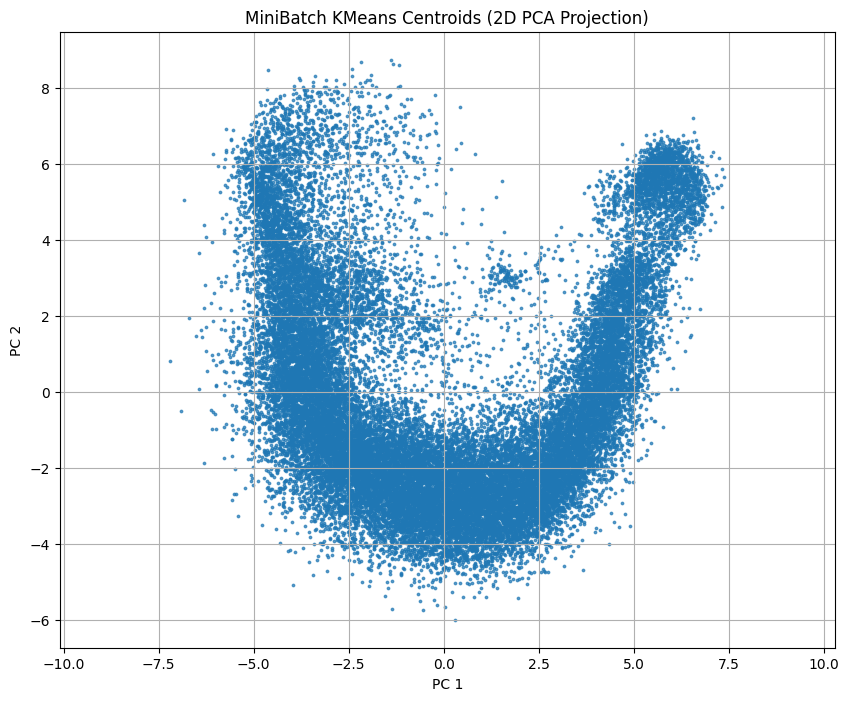

In [18]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

centroids_cpu = centroids.detach().cpu().numpy()

pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(centroids_cpu)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=3, alpha=0.7)
plt.title('MiniBatch KMeans Centroids (2D PCA Projection)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.axis('equal')
plt.show()

In [19]:
np.save('conv-centroids-v2.npy', centroids.cpu().numpy())